# Plots for Needle in Haystack Tests

In [1]:
import numpy as np
import matplotlib.pyplot as plt
#switch matplotlib font to Liberation Serif
plt.rcParams['font.family'] = 'Liberation Serif'

import logging
import pickle
from datetime import datetime
import os
from data_processing import gen_ckpt_steps
from conv_plots_funcs import get_seg_starts_per_config
import torch
import gc
from core.config import Config
from data_train import set_config_params, parameter_count
from models import GPT2

/home/sultand/interleaved_time_series/TFs_do_KF_ICL/src
Using device: cuda
/home/sultand/interleaved_time_series/TFs_do_KF_ICL/src
Using device: cuda


/home/sultand/.conda/envs/myenv310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Could not import netCDF4's package ==> I/O will not be available in this format
CUDA_VISIBLE_DEVICES: None


#### Experiment Details

In [ ]:
valA = "ident"
valC = "_ident_C"
state_dim = 5
ckpt_step = 141000
experiment = "250123_214343.0d4e0b_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000" # experiment to load
datasource = "val"
nope = True

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
errs_loc = errs_dir + f"/needle_{datasource}_" + f"{valA}_state_dim_{state_dim}_"
seg_ext_errs_loc = errs_dir + f"/needle_{datasource}_fin_seg_ext_" + f"{valA}_state_dim_{state_dim}_"


quartiles_file = model_dir + experiment + "/needles/quartiles.npz"

seg_ext_quartiles_file = model_dir + experiment + "/needles/seg_ext_quartiles.npz"

if os.path.exists(quartiles_file):
    print(f"Loading quartiles from {quartiles_file}")
    quartiles = np.load(quartiles_file)

if os.path.exists(seg_ext_quartiles_file):
    print(f"Loading seg ext quartiles from {seg_ext_quartiles_file}")
    seg_ext_quartiles = np.load(seg_ext_quartiles_file)


print(f"Errors location: {errs_loc}")

#### load the err_lss_examples at path which is numpy array

In [ ]:
with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
    err_lss_examples = pickle.load(f)

with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
    seg_ext_err_lss_examples = pickle.load(f)

In [ ]:
for key in err_lss_examples.keys():
    print(f"shape of examples[{key}]: {err_lss_examples[key].shape}")

for key in seg_ext_err_lss_examples.keys():
    print(f"shape of seg_ext_examples[{key}]: {seg_ext_err_lss_examples[key].shape}")

#### Compute the Quartiles

In [ ]:
def comp_quartiles(err_lss_examples, ratio=False, train_conv=False, kal_err=None):
    quartiles = {}
    if ratio:
        if not train_conv:
            kal_err = err_lss_examples["Kalman_rem"]

    for key in err_lss_examples.keys():
        if not (key == "Analytical_Kalman" or key == "Kalman_rem" or key == "Kalman"):
            if ratio:
                rat = err_lss_examples[key] / kal_err
            else:
                rat = err_lss_examples[key]
            med = np.median(rat, axis=2)
            # print(f"shape of med: {med.shape}")
            quartiles[key] = np.percentile(med, [25,50,75], axis=0)
            # print(f"shape of quartiles[{key}]: {quartiles[key].shape}")
            
    return quartiles


In [ ]:
if valA == "gaussA":
    rat = True
else:
    rat = False
quartiles = comp_quartiles(err_lss_examples, ratio=rat)

#save quartiles to npz file
os.makedirs(os.path.dirname(quartiles_file), exist_ok=True)
np.savez(quartiles_file, **quartiles)

In [ ]:
seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)

#save seg_ext_quartiles to npz file
os.makedirs(os.path.dirname(seg_ext_quartiles_file), exist_ok=True)
np.savez(seg_ext_quartiles_file, **seg_ext_quartiles)

## Plotting Code

### final trace

In [ ]:
haystack_len = quartiles["MOP"].shape[1]

print(f"quartiles[mop] shape: {quartiles['MOP'].shape}, seg_ext_quartiles[mop] shape: {seg_ext_quartiles['MOP'].shape}")

print(f"haystack_len: {haystack_len}")

In [ ]:
steps_in = [1,2,10]
open_paren_ind = 229
real_steps = [x + open_paren_ind for x in steps_in]
real_steps_ext = [x + open_paren_ind-2 for x in steps_in]

fig, ax = plt.subplots(len(steps_in), 1, sharex=True, figsize=(5, 2.7*len(steps_in))) #

#get a high contrast color map
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

print(f"real_steps: {real_steps}, real_steps_ext: {real_steps_ext}")


for needle in range(haystack_len):
    key_count = 0
    for key in quartiles.keys():
        print(f"key_count: {key_count}")
        if "OLS" not in key and "Simulation" not in key:
            # ax[needle].scatter(quartiles[key][1, needle], label=key)
            step_count = 0
            for step in steps_in:

                key_label = "TF" if key == "MOP" else key

                print(f"needle: {needle}, step: {step}, real_step: {real_steps[step_count]}")

                y = quartiles[key][1, needle, real_steps[step_count]]
                print(f"y: {y}")
                if valA == "gaussA":
                    y -= 1
                yerr = [
                    quartiles[key][1, needle, real_steps[step_count]] - quartiles[key][0, needle, real_steps[step_count]],
                    quartiles[key][2, needle, real_steps[step_count]] - quartiles[key][1, needle, real_steps[step_count]]
                ]#

                yerr = np.array([[yerr[0]], [yerr[1]]])
                if valA == "gaussA":
                   ax[step_count].errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=f"{key_label}" if needle == 0 else "_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=colors[key_count],
                    linewidth=2
                    )
                else:
                    if key == "Zero":
                        color = colors[1]
                    elif step == 1:
                        color = colors[0]
                    elif step == 2:
                        color = colors[2]
                    elif step == 10:
                        color = colors[3]
                    ax.errorbar(
                    haystack_len - needle - 1,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label=((f"{key_label}" + (f": {step} After Open" if key == "MOP" else "")) if (needle == 0 and key == "MOP") or (needle == 0 and step == 1) else "_nolegend_"),
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color=color,
                    linewidth=2
                    )

                step_count += 1
            key_count += 1

key_count = 0
for key in seg_ext_quartiles.keys():
    if "OLS" not in key and "Simulation" not in key:
        step_count = 0
        for step in steps_in:
            y = seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            if valA == "gaussA":
                y -= 1
            yerr = [
                seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][0, 0, real_steps_ext[step_count]],
                seg_ext_quartiles[key][2, 0, real_steps_ext[step_count]] - seg_ext_quartiles[key][1, 0, real_steps_ext[step_count]]
            ]

            yerr = np.array([[yerr[0]], [yerr[1]]])
            
            if valA == "gaussA":
                ax[step_count].errorbar(
                    -2,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label="_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color = colors[key_count], 
                    linewidth=2
                )
            else:
                if key == "Zero":
                    color = colors[1]
                elif step == 1:
                    color = colors[0]
                elif step == 2:
                    color = colors[2]
                elif step == 10:
                    color = colors[3]
                ax.errorbar(
                    -2 + step_count*0.02,
                    y,
                    yerr=yerr,  # Convert yerr to a (2, n) array-like structure
                    fmt='o',
                    label="_nolegend_",
                    capsize=5,
                    zorder=haystack_len if key == "MOP" else 0, color = color, 
                    linewidth=2
                )

            if valA != "gaussA":
                ax.legend(fontsize = 8, ncol=1, columnspacing=0.25)#, loc="upper left")
                ax.set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
                ax.set_ylabel(("(" if valA== "gaussA" else "") + "Error" + (" Ratio" if valA == "gaussA" else ""), fontsize=12)
                ax.set_xlim(-3, haystack_len)
                ax.grid(True)
                ax.minorticks_on()
                ax.grid(which='major', linestyle='--', linewidth='0.75', color='gray')
                # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
                #set the grid to be on integer values for x-axis
                ax.set_xticks(np.arange(-2, haystack_len, 1))
                ax.set_yscale('log')
                # ax[step_count].set_ylim(0.3, 3)
                ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)

            step_count += 1
        key_count += 1

if valA == "gaussA":
    for key in quartiles.keys():
        if "OLS" in key and "analytical" not in key:
            print(f"key_count: {key_count}")
            print(f"quartiles[{key}].shape: {quartiles[key].shape}")
            step_count = 0
            for step in steps_in:
                y = quartiles[key][1, :, real_steps[step_count]]
                y -= 1
                ax[step_count].axhline(y[0], label=key[:3] + "-" + key[7:], color=colors[key_count], linewidth=2, linestyle='-')


                ax[step_count].legend(fontsize = 10, ncol=5, columnspacing=0.4, handletextpad=0.25)#, loc="upper left")
                ax[step_count].set_xlabel("Needle Position from the End of the Haystack", fontsize=12, fontname="Times New Roman")
                ax[step_count].set_ylabel("Error" + (" Ratio" if valA == "gaussA" else "") + f": {step} After Open", fontsize=12)
                ax[step_count].set_xlim(-3, haystack_len)
                ax[step_count].grid(True)
                ax[step_count].minorticks_on()
                ax[step_count].grid(which='major', linestyle='--', linewidth='0.75', color='gray')
                # ax[step_count].grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
                #set the grid to be on integer values for x-axis
                ax[step_count].set_xticks(np.arange(-2, haystack_len, 1))
                ax[step_count].set_yscale('log')
                ax[step_count].set_ylim([2e-1, 3])
                ax[step_count].tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
                step_count += 1
            key_count += 1


fig.tight_layout()

plt.show()

os.makedirs(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}", exist_ok=True)
fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/error_ratios_{valA}_state_dim_{state_dim}{valC}_step_{ckpt_step}.pdf", transparent=True)



In [ ]:
if valA == "gaussA":
    quartilez_npz = quartiles
    seg_ext_quartiles_npz = seg_ext_quartiles
    quartiles = {key: quartiles[key] for key in quartiles.keys()}
    seg_ext_quartiles = {key: seg_ext_quartiles_npz[key] for key in seg_ext_quartiles_npz.keys()}
    for key in quartiles.keys():
        seg_ext_quartiles[key] -= 1
        quartiles[key] -= 1

In [ ]:
#make a figure with haystack_len subplots
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 3.5))
# fig, ax = plt.subplots(haystack_len, 1, sharex=True, figsize=(5, 5*haystack_len))

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

col_count = 0
dither = 0.05

open_paren_ind = 229
fin_seg_len = 250-open_paren_ind -1
x_values = np.arange(1, fin_seg_len+1)

print(f"haystack_len: {haystack_len}")
ax_count = 0
needle = haystack_len - 1
for key in quartiles.keys():
    if "OLS_analytical" not in key and "Simulation" not in key and key != "OLS_ir_2":
        ax.errorbar(x_values + col_count*dither, quartiles[key][1, needle][open_paren_ind+1:-1], yerr=[quartiles[key][1, needle][open_paren_ind+1:-1] - quartiles[key][0, needle][open_paren_ind+1:-1], quartiles[key][2, needle][open_paren_ind+1:-1] - quartiles[key][1, needle][open_paren_ind+1:-1]], fmt='o', label="TF: Final Segment" if key == "MOP" else (key[:3] + "-" + key[7:] if "OLS" in key else f"{key}"), capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
        col_count += 1

needle = 0
# for key in seg_ext_quartiles.keys():
#     if "OLS_analytical" not in key:



y_values = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_lower = seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][0, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]
yerr_upper = seg_ext_quartiles["MOP"][2, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len] - seg_ext_quartiles["MOP"][1, needle][open_paren_ind - 1:open_paren_ind - 1 + fin_seg_len]

ax.errorbar(x_values + dither*col_count, y_values, yerr=[yerr_lower, yerr_upper], fmt='o', label=f"TF w/o Punc.", capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
col_count += 1

needle = 0 #get the first needle
open_paren_ind = 1
key = "MOP"

fin_seg_len = 10

ax.errorbar(x_values[:10] + -dither, quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], yerr=[quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][0, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len], quartiles[key][2, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len] - quartiles[key][1, needle][open_paren_ind+1: open_paren_ind + 1 + fin_seg_len]], fmt='o', label="TF: Needle 0", capsize=2, zorder=haystack_len if key == "MOP" else 0, color=colors[col_count])
col_count += 1
        
ax.legend(ncol=3 if valA == "gaussA" else 1, fontsize=8)
ax.grid(which="both")
# ax.set_xlim(left=230, right=seg_ext_quartiles[key].shape[-1] - 1)  # set the x axis limits haystack_len*12 + 2
# ax.set_ylim(bottom=0, top=5.5)  # set the y axis limits

# Optionally, customize major and minor ticks
ax.minorticks_on()

# Set minor vertical grid lines to be on intervals of 1
# Set major ticks on every interval of 50
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

# Set minor vertical grid lines to be on intervals of 1
ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)

ax.tick_params(axis='both', which='major', length=7, width=1, labelsize=12)
ax.tick_params(axis='both', which='minor', length=4, width=0.5, labelsize=0)
ax.tick_params(axis='x', which='both', labelbottom=True, labelsize=12)
ax.grid(which='major', linestyle='-', linewidth=1)
ax.grid(which='minor', linestyle='--', linewidth=0.5)
ax.set_ylabel(f"Error" + (" Ratio" if valA == "gaussA" else ""), fontsize=14)
ax.set_xlabel("Steps after the Open Token", fontsize=14)
ax.set_yscale('log')
# ax.set_title(f"Prediction Error for Needle Position {needle}", fontsize=30)
if valA == "gaussA":
    ax.set_ylim([2e-1, 3])

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")

# #add a caption to the bottom of the figure
# fig.text(0.5, 0.1, f"Median of {num_examples} haystack configuration examples. step=" + str(ckpt_step) + "_" + timestamp, ha='center', fontsize=30)
plt.tight_layout()

fig.savefig(f"../outputs/GPT2/{experiment}/figures/multi_sys_trace/needle_in_haystack_examples/{datasource}/last_seg_context_{valA}.pdf", transparent=True)

# Needle in a Haystack: Training Convergence

In [ ]:
minval = 1000
maxval = 53000
interval = 1000
ckpt_steps = gen_ckpt_steps(minval, maxval, interval)
batch_size = 8192
gpus=1
vanilla = False
nope = False
experiments = ["250128_022331.067361_multi_sys_trace_ortho_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000", "250221_215216.337051_multi_sys_trace_ortho_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000"]

kal_ckpt = 126000
kal_err = None

if valA == "gaussA":
    rat = True
else:
    rat = False

model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

haystack_len = 1

fin_quartiles_ckpts = []
beg_quartiles_ckpts = []
x_values_list = []
for experiment in experiments:
    train_conv_fin_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_fin_quartiles_haystack_len_{haystack_len}.pkl"
    train_conv_beg_quartiles_file = model_dir + experiment + f"/needles/train_conv/train_conv_beg_quartiles_haystack_len_{haystack_len}.pkl"
    x_values_file = model_dir + experiment + f"/needles/train_conv/x_values_haystack_len_{haystack_len}.npy"



    if os.path.exists(train_conv_fin_quartiles_file):
        print(f"Loading train conv quartiles from {train_conv_fin_quartiles_file}")
        with open(train_conv_fin_quartiles_file, "rb") as f:
            fin_quartiles_ckpt = pickle.load(f)

    if os.path.exists(train_conv_beg_quartiles_file):
        print(f"Loading train conv quartiles from {train_conv_beg_quartiles_file}")
        with open(train_conv_beg_quartiles_file, "rb") as f:
            beg_quartiles_ckpt = pickle.load(f)

    if os.path.exists(x_values_file):
        x_values = np.load(x_values_file)

    fin_quartiles_ckpts.append(fin_quartiles_ckpt)
    beg_quartiles_ckpts.append(beg_quartiles_ckpt)
    x_values_list.append(x_values)

In [ ]:
steps_in = [1,2,3,5,10]

fig, ax = plt.subplots(max(2,haystack_len), 1, sharex=True, figsize=(5, 5))


quartiles_ckpt = []
pred_ckpts = []
last_pred_ckpt = 0
x_values = []
ys = {}
y_errs = {}
fin_quartiles_ckpt = {}
beg_quartiles_ckpt = {}

if valA == "gaussA":
    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={kal_ckpt}.ckpt"
    # errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_" 
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_"

    with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            kal_ckpt_errs = pickle.load(f)

    kal_err = kal_ckpt_errs["Kalman_rem"]

for ckpt_step in ckpt_steps:

    errs_dir = model_dir + experiment + f"/prediction_errors{valC}_step={ckpt_step}.ckpt"
    errs_loc = errs_dir + f"/single_system_" + f"{valA}_state_dim_{state_dim}_"
    errs_loc = errs_dir + f"/train_conv_needle_haystack_len_{haystack_len}_{datasource}_" + f"{valA}_state_dim_{state_dim}_" 

    if os.path.exists(errs_loc + "err_lss_examples.pkl"):
        print(f"loading errors for ckpt_step: {ckpt_step}")

        if len(pred_ckpts) > 0:
            last_pred_ckpt = pred_ckpts[-1]
            
            if valA == "ortho" and vanilla: #THIS IS FOR VANILLA ORTHO ONLY
                gpus = 2 #just for ortho case
            
            elif valA == "ident" and ckpt_step > 9600: #THIS IS FOR VANILLA IDENT ONLY
                gpus = 4

        else:
            last_pred_ckpt = 0
            if valA == "ortho":
                gpus = 3

        with open(errs_loc + "err_lss_examples.pkl", "rb") as f:
            err_lss_examples = pickle.load(f)

        # if os.path.exists(seg_ext_errs_loc + "err_lss_examples.pkl"):
        #     with open(seg_ext_errs_loc + "err_lss_examples.pkl", "rb") as f:
        #         seg_ext_err_lss_examples = pickle.load(f)

        if len(pred_ckpts) == 0:
            #get seg_starts
            seg_starts_per_conf = get_seg_starts_per_config(experiment, valA, valC, state_dim, ckpt_step, print_seg_starts=True, nope=nope, needle=True, haystack_len=haystack_len, train_conv=True)

        quartiles = comp_quartiles(err_lss_examples, ratio=rat, train_conv=True, kal_err=kal_err)

        del err_lss_examples
        #clear cuda cache
        torch.cuda.empty_cache()
        gc.collect()

        print(f"batch_size: {batch_size}, gpus: {gpus}, ckpt_step: {ckpt_step}, last_pred_ckpt: {last_pred_ckpt}")
        if len(x_values) > 0:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt) + x_values[-1]
        else:
            x_value = batch_size*gpus*(ckpt_step - last_pred_ckpt)

        print(f"x_value: {x_value}")
        x_values.append(x_value)
        for needle in range(1):
            fin_seg_start = seg_starts_per_conf[needle][-1]
            beg_seg_start = seg_starts_per_conf[needle][0]
            for step in steps_in:
                for key in ["MOP"]:
                    if "OLS_analytical" not in key and key not in  ["Zero", "Analytical_Simulation", "Kalman_rem", "Kalman", "Analytical_Kalman"]:
                        key_lab = "TF" if key == "MOP" else key
                        
                        y = quartiles[key][1, needle, fin_seg_start + step]
                        
                        y_err = [
                            [quartiles[key][1, needle, fin_seg_start + step] - quartiles[key][0, needle, fin_seg_start + step]],
                            [quartiles[key][2, needle, fin_seg_start + step] - quartiles[key][1, needle, fin_seg_start + step]]
                        ]

                        if needle == 0:
                            if len(pred_ckpts) == 0:
                                if step == 1:
                                    ys[key] = {}
                                    y_errs[key] = {}
                                    fin_quartiles_ckpt[key] = {}
                                    beg_quartiles_ckpt[key] = {}

                                    # for ir in range(1,4):
                                    #     ys[f"OLS_ir_{ir}"] = {}
                                    #     y_errs[f"OLS_ir_{ir}"] = {}
                                    #     fin_quartiles_ckpt[f"OLS_ir_{ir}"] = {}
                                    #     beg_quartiles_ckpt[f"OLS_ir_{ir}"] = {}


                                # print("step: ", step)
                                # print(f"key: {key}, step: {step}")
                                ys[key][step] = [y]
                                y_errs[key][step] = [y_err]
                                fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                                beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                            # elif ckpt_step == kal_ckpt and "OLS" in key:
                            #     ys[key][step] = [y]
                            #     y_errs[key][step] = [y_err]
                            #     fin_quartiles_ckpt[key][step] = [quartiles[key][:, needle, fin_seg_start + step]]
                            #     beg_quartiles_ckpt[key][step] = [quartiles[key][:, needle, beg_seg_start + step]]

                                # print(f"ys: {ys}")
                            else:
                                # print(f"ys: {ys}")
                                # print("step after minval: ", step)
                                # print(f"ys: {ys}")
                                # print(f"key: {key}, step: {step}")
                                ys[key][step].append(y)
                                y_errs[key][step].append(y_err)
                                fin_quartiles_ckpt[key][step].append(quartiles[key][:, needle, fin_seg_start + step])
                                beg_quartiles_ckpt[key][step].append(quartiles[key][:, needle, beg_seg_start + step])

                        ax[needle].errorbar(x_value, y, y_err, label=f"{key}: {step} after open" if ckpt_step == minval else "_nolegend_", capsize=5, markersize=5)

            
            ax[needle].set_xlabel("# of Training Examples", fontsize=12)
            ax[needle].set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else "") + f": Needle Position {needle}", fontsize=12)
            ax[needle].set_yscale('log')
            ax[needle].set_xscale('log')
            ax[needle].grid(True)
            ax[needle].legend(fontsize=8)
            ax[needle].set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)

        pred_ckpts.append(ckpt_step)
    else:
        print(f"path: {errs_loc + "err_lss_examples"} for ckpt_step: {ckpt_step} does not exist.")
   
plt.show()


os.makedirs(os.path.dirname(train_conv_fin_quartiles_file), exist_ok=True)
#save quartiles to pickle file
with open(train_conv_fin_quartiles_file, "wb") as f:
    pickle.dump(fin_quartiles_ckpt, f)

os.makedirs(os.path.dirname(train_conv_beg_quartiles_file), exist_ok=True)
#save quartiles to pickle file
with open(train_conv_beg_quartiles_file, "wb") as f:
    pickle.dump(beg_quartiles_ckpt, f)

os.makedirs(os.path.dirname(x_values_file), exist_ok=True)
np.save(x_values_file, x_values)


        # seg_ext_quartiles = comp_quartiles(seg_ext_err_lss_examples, ratio=rat)


In [ ]:
fig, ax = plt.subplots(1, 1, sharex=True, figsize=(7, 7))

colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651']
valA = "ortho"
if valA == "ortho":
    steps = [1,2,3,5,10]
else:
    steps = [1,2,3]

exp_count = 0
for experiment in experiments:
    x_values = x_values_list[exp_count]
    for key in fin_quartiles_ckpts[exp_count].keys():
        if key == "MOP":
            col_count = 0
            for step in steps:

                key_lab = "TF" if key == "MOP" else key
                qs = np.array(fin_quartiles_ckpts[exp_count][key][step])
                qs = np.transpose(qs)

                if valA == "gaussA":
                    qs -= 1

                #if key contains OLS then repeat the values in qs to be the length of x_values
                if "OLS" in key:
                    print(f"key: {key} qs shape: {qs.shape}")
                    qs = np.repeat(qs, len(x_values), axis=0)
                    print(f"qs shape after repeat: {qs.shape}")
                ax.plot(x_values, qs[1], label=f"{key_lab}: {step} after final" + (" (Accum)" if exp_count == 1 else ""), markersize=5, marker="." if exp_count == 0 else "<", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
                if not valA == "gaussA":
                    ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                beg_qs = np.array(beg_quartiles_ckpts[exp_count][key][step])
                beg_qs = np.transpose(beg_qs)
                #set the color to the same as the fin quartiles
                color = ax.get_lines()[-1].get_color()
                ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial" + (" (Accum)" if exp_count == 1 else ""), markersize=5, marker=("x" if exp_count == 0 else ">"), color=color, linestyle=("--" if exp_count == 0 else ":"), linewidth=2)

                if not valA == "gaussA":
                    ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

                col_count += 1
    exp_count += 1


ax.set_xlabel("# of Training Examples", fontsize=14)
ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" else ""), fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True, which="both")
ax.legend(fontsize=10, ncol=1, loc="lower left")
ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
# ax.set_ylim([5e-2, 3e0])
# ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")
plt.tight_layout()

os.makedirs(f"../outputs/grad_accum", exist_ok=True)
fig.savefig(f"../outputs/grad_accum/ortho_tiny_train_conv_haystack_len_{haystack_len}.pdf", transparent=True, format="pdf")

plt.show()

In [ ]:
print(qs)

## haystack length plot

In [2]:
from haystack_plots import load_quartiles_ckpt_files, load_quartiles
from get_last_checkpoint import split_path
import re
from data_train import set_config_params
from core import Config

plt.rcParams['text.usetex'] = False

In [3]:
def scientific_notation(value):
    """
    Returns the exponent and value of the scientific notation of an integer.
    
    Parameters:
    value (int): The integer to convert to scientific notation.
    
    Returns:
    tuple: A tuple containing the value and exponent of the scientific notation.
    """
    if value == 0:
        return (0, 0)
    
    exponent = 0
    while abs(value) >= 10:
        value /= 10
        exponent += 1
    while abs(value) < 1:
        value *= 10
        exponent -= 1

    value = round(value, 2)
    
    return (value, exponent)

In [ ]:
def extract_trace_string(file_path):
    match = re.search(r'trace_(.*?)_state', file_path)
    if match:
        return match.group(1)
    else:
        return None

def haystack_len_plot(config, experiment_dict, colors):
    exp_count = 0
    for experiment_path in experiment_dict.keys():
        valA = extract_trace_string(experiment_path)
        model_size = experiment_dict[experiment_path]
        nope = "NoPE" in experiment_path

        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))

        haystack_lens = np.arange(1,20)

        # model_dir = "../outputs/GPT2" + ("_NoPE" if nope else "") + "/"

        dither = 0.05

        # experiment = "250125_104123.f75c04_multi_sys_trace_ortho_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000"

        model_dir, experiment = split_path(experiment_path)

        for haystack_len in haystack_lens:
            print("haystack_len: ", haystack_len)
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)
            
            if fin_quartiles_ckpt is not None:
                steps = fin_quartiles_ckpt["MOP"].keys() #get the steps in from open token

                if valA != "ident":
                    #get early stop index
                    ref_step = 2
                    try:
                        ref_qs = np.array(fin_quartiles_ckpt["MOP"][ref_step]).T
                    except KeyError as e:
                        print(f"fin_quartiles_ckpt[\"MOP\"][{ref_step}] does not exist.")
                        raise e
                    
                    if valA == "gaussA":
                        ref_qs -= 1

                    early_stop_ind = np.argmin(ref_qs[1]) #get the index of the min value of the median for 2 after
                else:
                    early_stop_ind = -1 #get the last index


            else:
                print(f"fin_quartiles_ckpt is None for haystack_len: {haystack_len}\n\n")
                continue

            step_count = 0
            for step in steps:
                # print(f"step: {step}")
                qs = np.array(fin_quartiles_ckpt["MOP"][step]).T
                # print(f"qs shape: {qs.shape}")

                if valA == "gaussA":
                    qs -= 1

                    # ax.scatter(haystack_len + dither*step_count*(-1**step_count), qs[1,last_ind], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", s=100, marker=".", color=colors[step_count])

                # last_ind = len(qs[1]) - 1
                # print(f"\nx_value at last index: {x_values[last_ind]} for haystack_len: {haystack_len} and step: {step}\n")
                    
                ax.errorbar(haystack_len + dither*step_count*(-1**step_count), qs[1,early_stop_ind], yerr=[[qs[1,early_stop_ind] - qs[0,early_stop_ind]], [qs[2,early_stop_ind] - qs[1,early_stop_ind]]], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", markersize=8, marker=".", color=colors[step_count], capsize=5, linewidth=2)
                    
                step_count += 1

        ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 5))

        # Set minor vertical grid lines to be on intervals of 1
        ax.set_xticks(range(int(ax.get_xlim()[0]), int(ax.get_xlim()[1]) + 1, 1), minor=True)


        ax.set_xlabel("Haystack Length", fontsize=14)
        ax.set_ylabel(f"Error after {scientific_notation(early_stop_ind)[0]}e{scientific_notation(early_stop_ind)[1]} Training Traces" + ("Ratio" if valA == "gaussA" else ""), fontsize=14)
        ax.set_yscale('lin')
        ax.grid(True, which="both")
        ax.legend(fontsize=10)
        ax.set_xlim(0, 20)
        # ax.set_title(("NoPE " if nope else "") + ("Orthogonal " if valA == "ortho" else ("Gaussian " if valA == "gaussA" else "Identity ")) + f"Error vs Haystack Length: {model_size} Model")
        if valA == "gaussA":
            ax.set_ylim([2.7e-1, 3.5])
        elif valA == "ident":
            ax.set_ylim([2e-6, 4e-2])
        elif valA == "ortho":
            ax.set_ylim([3e-4, 0.06])
        timestamp = datetime.now().strftime("%Y%m%d_%H%M")

        fig.tight_layout()

        os.makedirs(experiment_path + f"/figures/multi_sys_trace/early_stop_err_vs_haystack_len", exist_ok=True)
        fig.savefig(experiment_path + f"/figures/multi_sys_trace/early_stop_err_vs_haystack_len/{valA}_early_stop_err_vs_haystack_len_{timestamp}.pdf", transparent=True, format="pdf")
        exp_count += 1
    return None


def phase_tr_vs_model_size(config, experiment_dict, haystack_len, cutoffs = [1.5, 0.5, 0.4], params=None):
    fig_gauss, ax_gauss = plt.subplots(1, 1, sharex=True, figsize=(4.3, 4.3))
    fig_ortho, ax_ortho = plt.subplots(1, 1, sharex=True, figsize=(4.3, 4.3))
    fig_ident, ax_ident = plt.subplots(1, 1, sharex=True, figsize=(4.3, 4.3))

    for exper in experiment_dict.keys():
        model_dir, experiment = split_path(exper)
        print(f"model_dir: {model_dir}, experiment: {experiment}")
        train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)

        valA = extract_trace_string(exper)
        model_size = experiment_dict[exper]


        nope = "NoPE" in exper

        if nope:
            continue
        else:
            if model_size == "tiny":
                num_params = params["tiny"]
            elif model_size == "small":
                num_params = params["small"]
            elif model_size == "medium":
                num_params = params["medium"]
            elif model_size == "big":
                num_params = params["big"]

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}, num_params: {num_params}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for haystack_len: {haystack_len}")
                continue
                
            if valA == "gaussA":
                qs -= 1
                ax = ax_gauss
                fig = fig_gauss
                cutoff_val = cutoffs[0]
            elif valA == "ortho_haar":
                ax = ax_ortho
                fig = fig_ortho
                cutoff_val = cutoffs[1]
            elif valA == "ident":
                ax = ax_ident
                fig = fig_ident
                cutoff_val = cutoffs[2]
            else:
                raise ValueError("valA must be one of 'gaussA', 'ortho', or 'ident'")
            
            #compute the index in qs for the last median value that comes before 0.5
            print("shape of qs[1]", qs[1].shape)
            larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
            smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
            print(f"larger_than_cutoff: {larger_than_cutoff}")
            print(f"smaller_than_cutoff: {smaller_than_cutoff}")

            if len(larger_than_cutoff) > 0:
                left_edge = larger_than_cutoff[-1]
                left_edge_x = x_values[left_edge]
            else:
                left_edge_x = np.inf

            if len(smaller_than_cutoff) > 0:
                right_edge = smaller_than_cutoff[0]
                right_edge_x = x_values[right_edge]
            else:
                right_edge_x = -np.inf

            block_width = (num_params)/1e1

            print(f"left_edge_x: {left_edge_x}, right_edge_x: {right_edge_x}, num_params: {num_params}, block_width: {block_width}")

            ax.fill_between([num_params - 0.5*block_width, num_params + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color="black")


    xlab = "Model Size (Parameters)"
    ylab = f"Training Examples to Reach Error"  +  (" Ratio" if valA == "gaussA" else "") + " of "
    plt_title = f"Phase Transition vs Model Size for Haystack Length {haystack_len}"
    # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
    ax_gauss.set_xlabel(xlab, fontsize=14)
    ax_gauss.set_ylabel(ylab + f"{cutoffs[0]}", fontsize=14)
    ax_gauss.set_yscale('log')
    ax_gauss.set_xscale('log')
    ax_gauss.grid(True, which="both")
    ax_gauss.set_xlim([3, 30])
    ax_gauss.set_ylim([1e7, 3.5e8])
    # ax_gauss.set_title("Gaussian")

    # ax_ortho.set_title(plt_title + " Orthogonal", fontsize=16)
    ax_ortho.set_xlabel(xlab, fontsize=14)
    ax_ortho.set_ylabel(ylab + f"{cutoffs[1]}", fontsize=14)
    ax_ortho.set_yscale('log')
    ax_ortho.set_xscale('log')
    ax_ortho.grid(True, which="both")
    ax_ortho.set_xlim([1e5, 2e7])
    ax_ortho.set_ylim([7e6, 1e8])
    # ax_ortho.set_title("Orthogonal")

    # ax_ident.set_title(plt_title + " Identity", fontsize=16)
    ax_ident.set_xlabel(xlab, fontsize=14)
    ax_ident.set_ylabel(ylab + f"{cutoffs[2]}", fontsize=14)
    ax_ident.set_yscale('log')
    ax_ident.set_xscale('log')
    ax_ident.grid(True, which="both")
    ax_ident.set_xlim([1e5, 2e7])
    ax_ident.set_ylim([2e5, 6.5e7])
    # ax_ident.set_title("Identity")


    fig_gauss.tight_layout()
    fig_ortho.tight_layout()
    fig_ident.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/model_size/", exist_ok=True)
    fig_gauss.savefig(f"../outputs/phase_transition/model_size/gauss_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ortho.savefig(f"../outputs/phase_transition/model_size/ortho_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ident.savefig(f"../outputs/phase_transition/model_size/ident_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    return None


def phase_tr_vs_haystack_len(config, experiment_dict, colors, cutoffs = [1.5, 0.5, 0.4]):
    haystack_lens = np.arange(1,20)
    dither = 0.05

    print(type(experiment_dict))

    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(5, 9))

    valA_dict = {"ident": 0, "ortho": 1, "gaussA": 2}
    model_dict = {"medium": 0, "big": 1, "small": 2, "tiny": 3, "nope": 4}

    for exper in experiment_dict.keys():

        

        model_dir, experiment = split_path(exper)
        for haystack_len in haystack_lens:
            print(f"model_dir: {model_dir}, experiment: {experiment}")
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)

            valA = extract_trace_string(exper)
            model_size = experiment_dict[exper]
            nope = "NoPE" in exper

            if nope:
                model_name = "nope"
            else:
                model_name = model_size

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for model_size: {model_size}")
                continue
                
            if valA == "gaussA":
                qs -= 1
                cutoff_val = cutoffs[0]
            elif valA == "ortho_haar":
                cutoff_val = cutoffs[1]
            elif valA == "ident":
                cutoff_val = cutoffs[2]
            else:
                raise ValueError("valA must be one of 'gaussA', 'ortho', or 'ident'")
            
            #compute the index in qs for the last median value that comes before 0.5
            print("shape of qs[1]", qs[1].shape)
            larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
            smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
            print(f"larger_than_cutoff: {larger_than_cutoff}")
            print(f"smaller_than_cutoff: {smaller_than_cutoff}")

            if len(larger_than_cutoff) > 0:
                left_edge = larger_than_cutoff[-1]
                left_edge_x = x_values[left_edge]
            else:
                left_edge_x = np.inf

            if len(smaller_than_cutoff) > 0:
                right_edge = smaller_than_cutoff[0]
                right_edge_x = x_values[right_edge]
            else:
                left_edge_x = -np.inf

            block_width = 0.25

            ax[valA_dict[valA]].fill_between([haystack_len + dither*(model_dict[model_name] - 1) - 0.5*block_width, haystack_len + dither*(model_dict[model_name] - 1) + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color=colors[model_dict[model_name]], label=(("NoPE " if nope else "") + f"{model_size}" ) if haystack_len == 1 else "_nolegend_")

        right_label = ("Identity" if valA == "ident" else ("Orthogonal" if valA == "ortho" else "Gaussian"))
        xlab = "Haystack Length"
        ylab = f"Training Examples to Error" +  (" Ratio" if valA == "gaussA" else "") + f" of {cutoff_val}"
        # ylab = f"Training Examples to Reach Error" + f" of {cutoff_val}"
        plt_title = f"Phase Transition vs Haystack Length"
        # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
        ax[valA_dict[valA]].set_xlabel(xlab, fontsize=12)
        ax[valA_dict[valA]].set_ylabel(ylab, fontsize=12)# Add a label along the right side of the plot
        ax[valA_dict[valA]].text(1.02, 0.5, right_label, transform=ax[valA_dict[valA]].transAxes, rotation=270, verticalalignment='center', fontsize=12)
        
        ax[valA_dict[valA]].set_yscale('log')
        ax[valA_dict[valA]].set_xscale('linear')
        ax[valA_dict[valA]].grid(True, which="both")
        ax[valA_dict[valA]].set_xlim([0, 20])
        #make ticks on the x-axis integers and grid lines on the x-axis integers
        ax[valA_dict[valA]].set_xticks(range(0, 21, 1))
        ax[valA_dict[valA]].legend(fontsize=8,ncol=5,loc="lower right", handletextpad=0.25, columnspacing=0.5)




    # fig.text(0.01, 0.5, ylab, rotation=90, verticalalignment='center', fontsize=12)
    fig.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/haystack_len/", exist_ok=True)
    # fig.savefig(f"../outputs/phase_transition/haystack_len/" + ("NoPE_" if nope else "") + f"{valA}_{model_size}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig.savefig(f"../outputs/phase_transition/haystack_len/" + f"phase_transition_conglomerate_{timestamp}.pdf", transparent=True, format="pdf")

    return None

def phase_tr_vs_lr(config, experiment_dict, haystack_len, colors, cutoffs = [0.5, 0.8]):
    fig_ortho, ax_ortho = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

    exper_count = 0
    for exper in experiment_dict.keys():
        model_dir, experiment = split_path(exper)
        print(f"model_dir: {model_dir}, experiment: {experiment}")
        train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)

        valA = extract_trace_string(exper)
        model_size = experiment_dict[exper]

        #extract the learning rate from the experiment string
        lr = float(experiment.split("lr_")[1].split("_")[0])
        print(f"lr: {lr}")


        nope = "NoPE" in exper

        if nope:
            continue
        else:
            if model_size == "tiny":
                num_params = 4
            elif model_size == "small":
                num_params = 5.7
            elif model_size == "medium":
                num_params = 9.1
            elif model_size == "big":
                num_params = 20.7

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}, num_params: {num_params}, lr: {lr}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][1]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for haystack_len: {haystack_len}")
                continue
                
            # if valA == "gaussA":
            #     qs -= 1
            #     ax = ax_gauss
            #     fig = fig_gauss
            #     cutoff_val = cutoffs[0]
            # elif valA == "ortho":
            #     ax = ax_ortho
            #     fig = fig_ortho
            #     cutoff_val = cutoffs[1]
            # elif valA == "ident":
            #     ax = ax_ident
            #     fig = fig_ident
            #     cutoff_val = cutoffs[2]
            # else:
            #     raise ValueError("valA must be one of 'gaussA', 'ortho', or 'ident'")

            ax = ax_ortho
            fig = fig_ortho
            count = 0
            for cutoff_val in cutoffs:
                
                #compute the index in qs for the last median value that comes before 0.5
                print("shape of qs[1]", qs[1].shape)
                larger_than_cutoff = np.where(qs[1] > cutoff_val)[0]
                smaller_than_cutoff = np.where(qs[1] < cutoff_val)[0]
                print(f"larger_than_cutoff: {larger_than_cutoff}")
                print(f"smaller_than_cutoff: {smaller_than_cutoff}")

                if len(larger_than_cutoff) > 0:
                    left_edge = larger_than_cutoff[-1]
                    left_edge_x = x_values[left_edge]
                else:
                    left_edge_x = -np.inf

                if len(smaller_than_cutoff) > 0:
                    right_edge = smaller_than_cutoff[0]
                    right_edge_x = x_values[right_edge]
                else:
                    right_edge_x = np.inf

                block_width = 5e-6 #(np.log(lr)/np.log(1.32e-5))

                ax.fill_between([lr - 0.5*block_width, lr + 0.5*block_width], [left_edge_x]*2, [right_edge_x]*2, alpha=1, color=colors[count], label=f"Cutoff value: {cutoff_val}" if exper_count == 0 else "_nolegend_")
                count+=1
        exper_count += 1


    xlab = "Learning Rate"
    ylab = f"# of Training Examples"
    plt_title = f"Phase Transition vs Learning Rate for Haystack Length {haystack_len}"
    # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
    # ax_gauss.set_xlabel(xlab, fontsize=14)
    # ax_gauss.set_ylabel(ylab + f"{cutoffs[0]}", fontsize=14)
    # ax_gauss.set_yscale('log')
    # ax_gauss.set_xscale('log')
    # ax_gauss.grid(True, which="both")
    # ax_gauss.set_xlim([3, 30])
    # ax_gauss.set_ylim([1e7, 3.5e8])

    # ax_ortho.set_title(plt_title + " Orthogonal", fontsize=16)
    ax_ortho.set_xlabel(xlab, fontsize=14)
    ax_ortho.set_ylabel(ylab, fontsize=14)
    ax_ortho.set_yscale('log')
    ax_ortho.set_xscale('linear')
    ax_ortho.grid(True, which="both")
    # ax_ortho.set_xlim([3, 30])
    # ax_ortho.set_ylim([7e6, 3e8])
    ax_ortho.legend(fontsize=10, ncol=2, loc="upper right")

    # ax_ident.set_title(plt_title + " Identity", fontsize=16)
    # ax_ident.set_xlabel(xlab, fontsize=14)
    # ax_ident.set_ylabel(ylab + f"{cutoffs[2]}", fontsize=14)
    # ax_ident.set_yscale('log')
    # ax_ident.set_xscale('log')
    # ax_ident.grid(True, which="both")
    # ax_ident.set_xlim([3, 30])
    # ax_ident.set_ylim([2e5, 6.5e7])


    # fig_gauss.tight_layout()
    fig_ortho.tight_layout()
    # fig_ident.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/lr/", exist_ok=True)
    # fig_gauss.savefig(f"../outputs/phase_transition/model_size/gauss_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ortho.savefig(f"../outputs/phase_transition/lr/ortho_haystack_len_{haystack_len}_phase_transition_lr_{timestamp}.pdf", transparent=True, format="pdf")
    # fig_ident.savefig(f"../outputs/phase_transition/model_size/ident_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    return None

def two_after_vs_lr(config, experiment_dict, haystack_len):
    fig_ortho, ax_ortho = plt.subplots(1, 1, sharex=True, figsize=(5, 5))

    for exper in experiment_dict.keys():
        model_dir, experiment = split_path(exper)
        print(f"model_dir: {model_dir}, experiment: {experiment}")
        train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)

        valA = extract_trace_string(exper)
        model_size = experiment_dict[exper]

        #extract the learning rate from the experiment string
        lr = float(experiment.split("lr_")[1].split("_")[0])
        print(f"lr: {lr}")


        nope = "NoPE" in exper

        if nope:
            continue
        else:
            if model_size == "tiny":
                num_params = 4
            elif model_size == "small":
                num_params = 5.7
            elif model_size == "medium":
                num_params = 9.1
            elif model_size == "big":
                num_params = 20.7

            print(f"\n\nexperiment: {experiment}, model_size: {model_size}, num_params: {num_params}, lr: {lr}")
            try:
                qs = np.array(fin_quartiles_ckpt["MOP"][2]).T
            except TypeError:
                print(f"FIN QUARTILES RETURNED NONE")
                print(f"fin_quartiles_ckpt: {fin_quartiles_ckpt}\n\n")
                continue

            if x_values is None:
                print(f"x_values is None for haystack_len: {haystack_len}")
                continue
                
            # if valA == "gaussA":
            #     qs -= 1
            #     ax = ax_gauss
            #     fig = fig_gauss
            #     cutoff_val = cutoffs[0]
            # elif valA == "ortho":
            #     ax = ax_ortho
            #     fig = fig_ortho
            #     cutoff_val = cutoffs[1]
            # elif valA == "ident":
            #     ax = ax_ident
            #     fig = fig_ident
            #     cutoff_val = cutoffs[2]
            # else:
            #     raise ValueError("valA must be one of 'gaussA', 'ortho', or 'ident'")

            ax = ax_ortho
            fig = fig_ortho
            ind = 7

            if lr > 5e-5:
                plot_ind = ind - 1
                print("lr in if: ", lr)
            else:
                plot_ind = ind

            #compute the index in qs for the last median value that comes before 0.5
            # print("shape of qs[1]", qs[1].shape)
            ax.errorbar(lr, qs[1][plot_ind] , yerr=[[qs[1][plot_ind] - qs[0][plot_ind]], [qs[2][plot_ind] - qs[1][plot_ind]]], capsize=5, markersize=5, marker=".", color="black")

    
    xlab = "Learning Rate"
    ylab = f"Error"  +  (" Ratio" if valA == "gaussA" else "") + f" of 2 After Final at {(ind + 1)*1000*2048*2}"
    plt_title = f"Phase Transition vs Learning Rate for Haystack Length {haystack_len}"
    # ax_gauss.set_title(plt_title + " Gaussian", fontsize=16)
    # ax_gauss.set_xlabel(xlab, fontsize=14)
    # ax_gauss.set_ylabel(ylab + f"{cutoffs[0]}", fontsize=14)
    # ax_gauss.set_yscale('log')
    # ax_gauss.set_xscale('log')
    # ax_gauss.grid(True, which="both")
    # ax_gauss.set_xlim([3, 30])
    # ax_gauss.set_ylim([1e7, 3.5e8])

    # ax_ortho.set_title(plt_title + " Orthogonal", fontsize=16)
    ax_ortho.set_xlabel(xlab, fontsize=14)
    ax_ortho.set_ylabel(ylab, fontsize=14)
    ax_ortho.set_yscale('log')
    ax_ortho.set_xscale('linear')
    ax_ortho.grid(True, which="both")
    # ax_ortho.set_xlim([3, 30])
    # ax_ortho.set_ylim([7e6, 3e8])

    # ax_ident.set_title(plt_title + " Identity", fontsize=16)
    # ax_ident.set_xlabel(xlab, fontsize=14)
    # ax_ident.set_ylabel(ylab + f"{cutoffs[2]}", fontsize=14)
    # ax_ident.set_yscale('log')
    # ax_ident.set_xscale('log')
    # ax_ident.grid(True, which="both")
    # ax_ident.set_xlim([3, 30])
    # ax_ident.set_ylim([2e5, 6.5e7])


    # fig_gauss.tight_layout()
    fig_ortho.tight_layout()
    # fig_ident.tight_layout()

    timestamp = datetime.now().strftime("%Y%m%d_%H%M")

    os.makedirs("../outputs/phase_transition/lr/", exist_ok=True)
    # fig_gauss.savefig(f"../outputs/phase_transition/model_size/gauss_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    fig_ortho.savefig(f"../outputs/phase_transition/lr/ortho_haystack_len_{haystack_len}_2_after_lr_{timestamp}.pdf", transparent=True, format="pdf")
    # fig_ident.savefig(f"../outputs/phase_transition/model_size/ident_haystack_len_{haystack_len}_phase_transition_{timestamp}.pdf", transparent=True, format="pdf")
    return None

def slice_vs_haystack_len(config, experiment_dict, steps_in, colors=['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']):

    exper_roughs = {"tiny": 4e7, "small": 1e7, "medium": 6.24e7, "big": 1e6}
    for exper in experiment_dict.keys():
        fig, ax = plt.subplots(1, 1, sharex=True, figsize=(8,3))
        fig_loglog, ax_loglog = plt.subplots(1, 1, sharex=True, figsize=(4,4))
        slice = None #set to None to get the x_values near 2e6 for each experiment
        model_dir, experiment = split_path(exper)
        print(f"model_dir: {model_dir}, experiment: {experiment}")
        for haystack_len in range(1, 20):
            train_conv_fin_quartiles_file, train_conv_beg_quartiles_file, x_values_file, fin_quartiles_ckpt, beg_quartiles_ckpt, x_values = load_quartiles_ckpt_files(config, haystack_len, model_dir, experiment)
            print(f"x_values_file: {x_values_file}")
            
            valA = extract_trace_string(exper)
            model_size = experiment_dict[exper]

            if slice is None:
                #get x_value near exper_roughs[model_size]
                slice_ind = np.where(x_values > exper_roughs[model_size])[0][0]
                slice = x_values[slice_ind]
                print(f"slice_ind: {slice_ind}, slice: {slice}")
            dither = 0.01
            col_count = 0
            for step in steps_in:
                if fin_quartiles_ckpt is not None:
                    qs = np.array(fin_quartiles_ckpt["MOP"][step]).T
                    qs_slice = qs[:,slice_ind]
                    qs_loglog = -qs_slice + 1
                else:
                    print(f"fin_quartiles_ckpt is None for haystack_len: {haystack_len}\n\n")
                    continue

                ax.errorbar(haystack_len + col_count*dither*(-1)**(col_count), qs_slice[1], yerr=[[qs_slice[1] - qs_slice[0]], [qs_slice[2] - qs_slice[1]]], capsize=5, markersize=8, marker=".", color=colors[col_count], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_", zorder=1 if step == 1 else 0, linewidth=2)

                ax_loglog.errorbar(haystack_len, qs_loglog[1], yerr=[[qs_loglog[1] - qs_loglog[2]], [qs_loglog[0] - qs_loglog[1]]], capsize=5, markersize=5, marker=".", color=colors[col_count], label=f"TF: {step} after final" if haystack_len == 1 else "_nolegend_")
                col_count += 1

        #scientific notation for slice
        slice_sci = scientific_notation(slice)
        xlab = "# of Systems in the Haystack"
        # ylab = f"Error at ${slice_sci[0]}\\times 10^{{slice_sci[1]}}$ Examples" #with latex
        ylab = f"Error at {slice_sci[0]}e{slice_sci[1]} Examples"
        ax.set_xlabel(xlab, fontsize=12)
        ax.set_ylabel(ylab, fontsize=12)
        ax.set_yscale('linear')
        ax.set_xscale('linear')
        #set x-axis ticks to be integers
        ax.set_xticks(range(0, 21, 1))
        #set grid lines only for y-axis
        ax.grid(True, which="both", axis='y')
        ax.set_xlim([0, 20])
    
        ax.legend()

        ax_loglog.set_xlabel(xlab, fontsize=12)
        ax_loglog.set_ylabel("1 - " + ylab, fontsize=12)
        ax_loglog.set_yscale('log')
        ax_loglog.set_xscale('log')
        ax_loglog.grid(True, which="both")
        ax_loglog.set_xlim([0, 20])
        ax.legend()


        timestamp = datetime.now().strftime("%Y%m%d_%H%M")
        fig_path = exper + "/figures/multi_sys_trace/slice_vs_haystack_len"
        os.makedirs(fig_path, exist_ok=True)
        fig.tight_layout()

        fig.savefig(fig_path + f"/{valA}_{model_size}_slice_vs_haystack_len_linscale_{timestamp}.pdf", transparent=True, format="pdf")
        fig_loglog.tight_layout()
        fig_loglog.savefig(fig_path + f"/{valA}_{model_size}_slice_vs_haystack_len_logscale_{timestamp}.pdf", transparent=True, format="pdf")

    return None

SyntaxError: f-string: invalid syntax. Perhaps you forgot a comma? (3753561167.py, line 80)

In [ ]:
ls = np.array([[1e-1,2e-1, 6e-1],[1e-1,1e-2, 1e-1],[1e-1,2e-1, 4e-1]])@np.array([[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10],[1,2,3,4,5,6,7,8,9,10]])
print("shape of ls: ", ls.shape)
print(ls)
print("where shape: ", np.where(ls[1] > 0.5))
first_ind = np.where(ls[1] > 0.5)[0][0]
last_ind = np.where(ls[1] < 0.5)[0][-1]
print("last_ind: ", last_ind)
print("first_ind: ", first_ind)

In [7]:
colors = ['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']
experiment_paths = ["../outputs/GPT2/250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.00012679145539688913_num_train_sys_40000", "../outputs/GPT2/250507_024037.72e4da_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_4.4827548953825996e-05_num_train_sys_40000", "../outputs/GPT2/250418_125901.8d6b22_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000", "../outputs/GPT2/250128_022310.fc649a_multi_sys_trace_ident_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000", "../outputs/GPT2/250125_110549.80eba5_multi_sys_trace_ident_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000", "../outputs/GPT2/250124_052617.8dd0f8_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250125_210849.09203d_multi_sys_trace_ident_state_dim_5_ident_C_lr_1.3207437987531975e-05_num_train_sys_40000"]



model_sizes = ["tiny", "small", "medium", "big", "tiny", "small", "medium", "big"]

print(len(experiment_paths))

print(len(model_sizes))

experiment_dict = dict(zip(experiment_paths, model_sizes))
print(type(experiment_dict))

valA = extract_trace_string(experiment_paths[2])
print(f"valA: {valA}")

print(f"is NoPE in experiment_paths[0]: {'NoPE' in experiment_paths[3]}")




8
8
<class 'dict'>
valA: ortho_haar
is NoPE in experiment_paths[0]: False


In [8]:
model_names = ["ortho_haar_tiny", "ortho_haar_small", "ortho_haar_medium_single_gpu", "ortho_haar_big", "ident_tiny", "ident_small", "ident", "ident_big"]

params = {}

count = 0
for model_name in model_names:
    config = Config()

    output_dir, ckpt_dir, experiment_name = set_config_params(config, model_name)

    config.override("late_start", None)
    config.override("datasource", "val") # set the datasource in the config object
    config.override("acc", False) # set the acc in the config object for using the ACCESS server

    config.override("multi_cut_val", False) # set the multi_cut_val in the config object

    # config.override("late_start", late_start) # set the late_start in the config object
    config.override("late_start", None)

    config.override("paren_swap", False) # set the paren_swap in the config object

    config.override("same_tokens", False) # set the same_tokens in the config object

    config.override("irrelevant_tokens", False) # set the irrelevant_tokens in the config object

    config.override("fix_needle", False) # set the fix_needle in the config object

    config.override("new_hay_insert", False) # set the new_hay_insert in the config object

    config.override("opposite_ortho", False) # set the opposite_ortho in the config object

    config.override("only_beg", False) # set the only_beg in the config object

    device = "cuda" if torch.cuda.is_available() else "cpu"  # check if cuda is available

    ckpt = 1000
    filename = f"step={ckpt}.ckpt"
    ckpt_path = ckpt_dir + "/checkpoints/" + filename

    config.override("ckpt_path", ckpt_path)
    #load model from ckpt_dir``
    model = GPT2.load_from_checkpoint(config.ckpt_path,
                                    n_dims_in=config.n_dims_in, n_positions=config.n_positions,
                                    n_dims_out=config.n_dims_out, n_embd=config.n_embd,
                                    n_layer=config.n_layer, n_head=config.n_head, use_pos_emb=config.use_pos_emb, map_location=device, strict=True).eval().to(device)

    print(model)

    model_params = parameter_count(model, config.n_positions)
    print(f"{model_name} params: {model_params}")
    params[model_sizes[count]] = model_params
    count += 1





ORTHO HAAR TINY MODEL


GPT2(
  (_read_in): Linear(in_features=57, out_features=72, bias=True)
  (_backbone): GPT2Model(
    (wte): Embedding(50257, 72)
    (wpe): Embedding(2048, 72)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-2): 3 x GPT2Block(
        (ln_1): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=216, nx=72)
          (c_proj): Conv1D(nf=72, nx=72)
          (attn_dropout): Dropout(p=0.0, inplace=False)
          (resid_dropout): Dropout(p=0.0, inplace=False)
        )
        (ln_2): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=288, nx=72)
          (c_proj): Conv1D(nf=72, nx=288)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((72,), eps=1e-05, elementwise_affine=True)
  )
  (_read_out): Linear(in_features=72, out_features=5, bias=Tr

In [ ]:
print(f"params: {params}")
for key in params.keys():
    sci = scientific_notation(params[key])
    print(f"{key}: {sci[0]}e{sci[1]}")

In [ ]:
haystack_lens = np.arange(1,20)
for haystack_len in haystack_lens:
    phase_tr_vs_model_size(config, experiment_dict, haystack_len, params=params)

In [ ]:
phase_tr_vs_haystack_len(config, experiment_dict, colors)

haystack_len:  1
config.val_dataset_typ: ident
config.irrelevant_tokens: False, config.new_hay_insert: False
Loading train conv quartiles from ../outputs/GPT2/250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.00012679145539688913_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading train conv quartiles from ../outputs/GPT2/250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.00012679145539688913_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
Loading x_values from ../outputs/GPT2/250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.00012679145539688913_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy
haystack_len:  2
config.val_dataset_typ: ident
config.irrelevant_tokens: False, config.new_hay_insert: False
Loading train conv quartiles from ../outputs/GPT2/250508_234147.a7058e_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_0.000126

IndexError: list index out of range

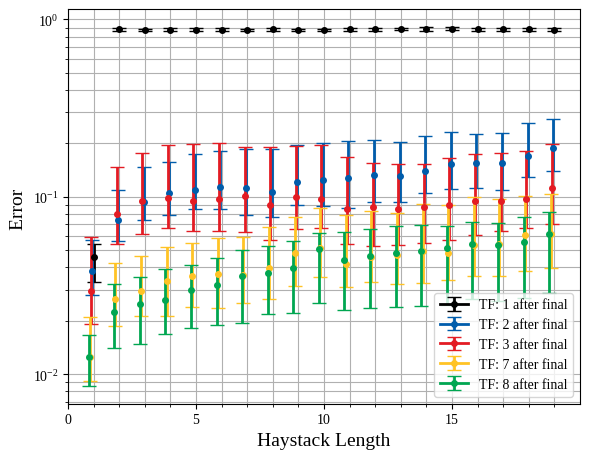

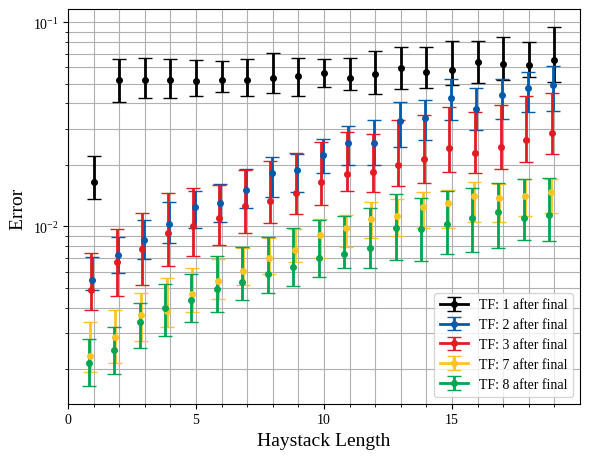

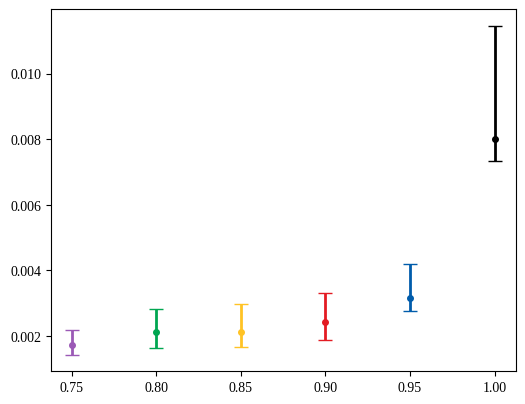

In [9]:
haystack_len_plot(config, experiment_dict, colors)

In [ ]:
lr_experiment_paths = ["../outputs/GPT2/250128_022331.067361_multi_sys_trace_ortho_state_dim_5_ident_C_lr_6.339572769844456e-05_num_train_sys_40000", "../outputs/GPT2/250212_222339.54331c_multi_sys_trace_ortho_state_dim_5_ident_C_lr_3.169786384922228e-05_num_train_sys_40000", "../outputs/GPT2/250212_222500.72ce84_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000", "../outputs/GPT2/250215_185541.3091e0_multi_sys_trace_ortho_state_dim_5_ident_C_lr_1.3207437987531975e-05_num_train_sys_40000"]

lr_model_sizes = ["tiny", "tiny", "tiny", "tiny"]

lr_experiment_dict = dict(zip(lr_experiment_paths, lr_model_sizes))

# haystack_lens = np.arange(1,20)
# for haystack_len in haystack_lens:
#     phase_tr_vs_lr(config, lr_experiment_dict, haystack_len)

phase_tr_vs_lr(config, lr_experiment_dict, 1, colors, cutoffs=[0.5, 0.7])



In [ ]:
two_after_vs_lr(config, lr_experiment_dict, 1)

In [ ]:
# out of the experiment_paths list, create a list that only contains experiments that have "ident_state_dim" in them
ident_experiment_paths = [exper for exper in experiment_paths if "ident_state_dim" in exper and "NoPE" not in exper]
# print("ident_experiment_paths: ", ident_experiment_paths)
ident_model_sizes = ["medium", "small", "big", "tiny"]

ident_experiment_dict = dict(zip(ident_experiment_paths, ident_model_sizes))





In [ ]:
slice_vs_haystack_len(config, ident_experiment_dict)

In [ ]:
exp_dict = {"../outputs/GPT2/250418_125901.8d6b22_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.584893192461114e-05_num_train_sys_40000": "medium"}

config = Config()
set_config_params(config, "ortho_haar_medium_single_gpu")
late_start = None
paren_swap = False
same_tokens = False
irrelevant_tokens = False
fix_needle = False
new_hay_insert = False
opposite_ortho = False
only_beg = False
fix_needle =False
datasource = "val"
acc = False


config.override("datasource", datasource) # set the datasource in the config object
config.override("acc", acc) # set the acc in the config object for using the ACCESS server

# config.override("late_start", late_start) # set the late_start in the config object
config.override("late_start", late_start)

config.override("paren_swap", paren_swap) # set the paren_swap in the config object
if config.paren_swap:
    print("Running paren swap experiment\n\n\n")

config.override("same_tokens", same_tokens) # set the same_tokens in the config object
if config.same_tokens:
    print("Running same tokens experiment\n\n\n")

config.override("irrelevant_tokens", irrelevant_tokens) # set the irrelevant_tokens in the config object
if config.irrelevant_tokens:
    print("Running irrelevant tokens experiment\n\n\n")

config.override("fix_needle", fix_needle) # set the fix_needle in the config object
if config.fix_needle:
    print("Running fix needle experiment\n\n\n")

config.override("new_hay_insert", new_hay_insert) # set the new_hay_insert in the config object
if config.new_hay_insert:
    print("Running new hay insertion experiment\n\n\n")

config.override("opposite_ortho", opposite_ortho) # set the opposite_ortho in the config object
if config.opposite_ortho:
    config.override("val_dataset_typ", "ortho")

config.override("only_beg", only_beg) # set the only_beg in the config object
if config.only_beg:
    print("only plotting the beginning evals\n\n\n")

slice_vs_haystack_len(config, exp_dict, steps_in=[1, 2, 3, 7, 8])

## 2-after investigation

In [ ]:
steps = [2]

fig, ax = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))
fig_len, ax_len = plt.subplots(1, 1, sharex=True, figsize=(6, 4.7))


for key in fin_quartiles_ckpt.keys():
    if key == "MOP":
        col_count = 0
        for step in steps:

            key_lab = "TF" if key == "MOP" else key
            qs = np.array(fin_quartiles_ckpt[key][step])
            qs = np.transpose(qs)

            # #if key contains OLS then repeat the values in qs to be the length of x_values
            # if "OLS" in key:
            #     print(f"key: {key} qs shape: {qs.shape}")
            #     qs = np.repeat(qs, len(x_values), axis=0)
            #     print(f"qs shape after repeat: {qs.shape}")

            if step == 2:
                #find the index of the minimum of qs[1]
                early_stop_ind = np.argmin(qs[1])
                print(f"early_stop_ind: {early_stop_ind}, x_values[early_stop_ind]: {x_values[early_stop_ind]}")

                # raise NotImplementedError("Check the early stop index")
            
            ax.plot(x_values, qs[1], label=f"{key_lab}: {step} after final", markersize=5, marker=".", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
            # if not valA == "gaussA":
            #     ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

            ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

            ax_len.plot(x_values, qs[1], label=f"{key_lab}: {step} after final", markersize=5, marker=".", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
            ax_len.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

            beg_qs = np.array(beg_quartiles_ckpt[key][step])
            beg_qs = np.transpose(beg_qs)
            #set the color to the same as the fin quartiles
            color = ax.get_lines()[-1].get_color()
            ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial", markersize=5, marker="x", color=color, linestyle="--", linewidth=2)

            # if not valA == "gaussA":
            #     ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)
            ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

            ax_len.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial", markersize=5, marker="x", color=color, linestyle="--", linewidth=2)
            ax_len.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

            col_count += 1

# plt.tight_layout()
# plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)  # Adjust margins as needed

ax.set_xlabel("# of Training Examples", fontsize=14)
ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
ax.set_yscale('log')
ax.set_xscale('log')
ax.grid(True, which="both")
ax.legend(fontsize=10, ncol=2 if valA =="ident" else 1, loc="lower left")
ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
# ax.set_ylim([5e-2, 3e0])
# ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")

ax_len.set_xlabel("# of Training Examples", fontsize=14)
ax_len.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
ax_len.set_yscale('linear')
ax_len.set_xscale('log')
ax_len.grid(True, which="both")
ax_len.legend(fontsize=10, ncol=2 if valA =="ident" else 1, loc="lower left") #"center right" if valA == "ident" else 
ax_len.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)

#add the date and time to the filename
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")


figure_dir = f"../outputs/GPT2" + ("_NoPE" if nope else "") + f"/{experiment}/figures/multi_sys_trace/" + (f"{config.datasource}/" if config.datasource != "val" else "") + ("paren_swap/" if config.paren_swap else "") 
os.makedirs(figure_dir, exist_ok=True)
print(figure_dir + (f"late_start_{config.late_start}_" if config.late_start is not None else "") + ("abs_err_" if abs_err else "") + f"{valA}_train_conv_haystack_len_{haystack_len}_{timestamp}_logscale.pdf")

fig.tight_layout()
fig_len.tight_layout()

fig.savefig(figure_dir + ("paren_swap_" if config.paren_swap else "") + (f"late_start_{config.late_start}_" if config.late_start is not None else "") + ("abs_err_" if abs_err else "") + f"{valA}_embd_dim_{config.n_embd}_train_conv_haystack_len_{haystack_len}_{timestamp}_logscale.pdf", transparent=True, format="pdf")

fig_len.savefig(figure_dir + ("paren_swap_" if config.paren_swap else "") + (f"late_start_{config.late_start}_" if config.late_start is not None else "") + ("abs_err_" if abs_err else "") + f"{valA}_embd_dim_{config.n_embd}_train_conv_haystack_len_{haystack_len}_{timestamp}_linearscale.pdf", transparent=True, format="pdf")

plt.show()

In [ ]:
import numpy as np

array = np.array([
    [-0.18800438,  0.68760724,  0.49110098,  0.47159198,  0.16814123],
    [-0.01220447, -0.63030999,  0.48053924,  0.20964428,  0.57244361],
    [-0.82839971,  0.0770947,  -0.13746996, -0.41937329,  0.3362118],
    [-0.48358783, -0.32998874,  0.3120087,   0.21858815, -0.71562562],
    [ 0.21071813,  0.12275762,  0.64160304, -0.71413973, -0.13739881]
])